## Assignment 2 - Clustering

## Learning Outcomes

In this assignment, you will do the following:

* Explore a dataset and carry out clustering using k-means algorithm

* Identify the optimum number of clusters for a given dataset



## Problem Description

In this assignment, you will study the electricity demand from clients in Portugal, during 2013 and 2014. You have been provided with the data file, which you should download when you download this assignment file.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise, you will use clustering techniques to understand the typical usage behaviour during 2013-2014.

Both these datasets are publicly available, and can be used to carry out experiments. Their source is below:

 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm

We will start by exploring the data set and continue on to the assignment.  Consider this as a working notebook, you will add your work to the same notebook.

In this assignment we will use the sklearn package for k-means.  Please refer here for the documentation https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
(https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

The sklearn package for k-means is one of the many clustering algorithms found in the module "sklearn.cluster".  These come with a variety of functions that you can call by importing the package.

For example 
    
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.cluster import KMeans



## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed. The data file has been provided with this assignment. It is also available at the links provided above.

In [5]:
pathToFile = r"C:\Users\frank\Desktop\ML Docs\uWaterloo(DataScience)\3_Machine_Learning_New\Assignment_2\\" #r"C:\\path\\to\\file\\"  
#pathToFile = r"C:\\Users\\<your username>\\Downloads\\"

fileName = 'LD2011_2014.txt'

In [7]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [9]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [11]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [14]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [18]:
data.shape

(140256, 370)

#### As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [23]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the first 2 days of 2012 for the first 2 clients

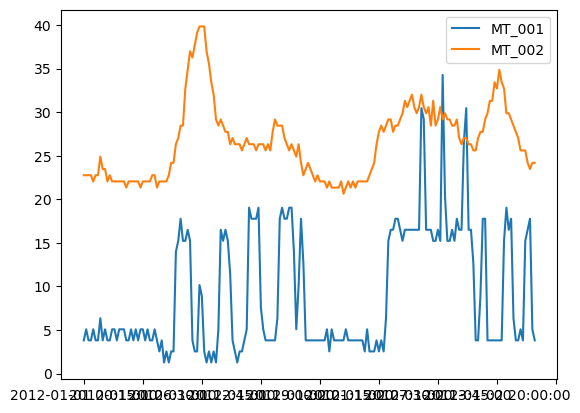

In [26]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We  note that the main difference between the curves is the level (also seen on the means in df.describe()).  We know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with low number of clients having zero demand

In [30]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [32]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [34]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [36]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013._append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [39]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [41]:
data['hour'] = data.index.map(lambda x: x[11:])

In [43]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [46]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [49]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

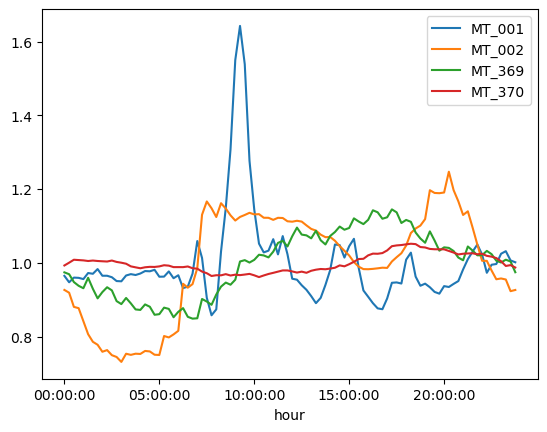

In [52]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [55]:
X = average_curves_norm.copy()  # We call this normalized curve
X = np.array(X.T) # put it on the right format

# Questions (15 marks total)

**Q1: (7 marks)**

a. Determine what a convenient number of clusters. Justify your choice.  Make use of the sklearn's package for k-means for this. You may refer to the module to figure out how to come up with the optimal number of clusters. 

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the center of the cluster (make this curve thicker to distinguish it from the individual curves).  The center is also sometimes referred to as "centroid".
    
You have 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

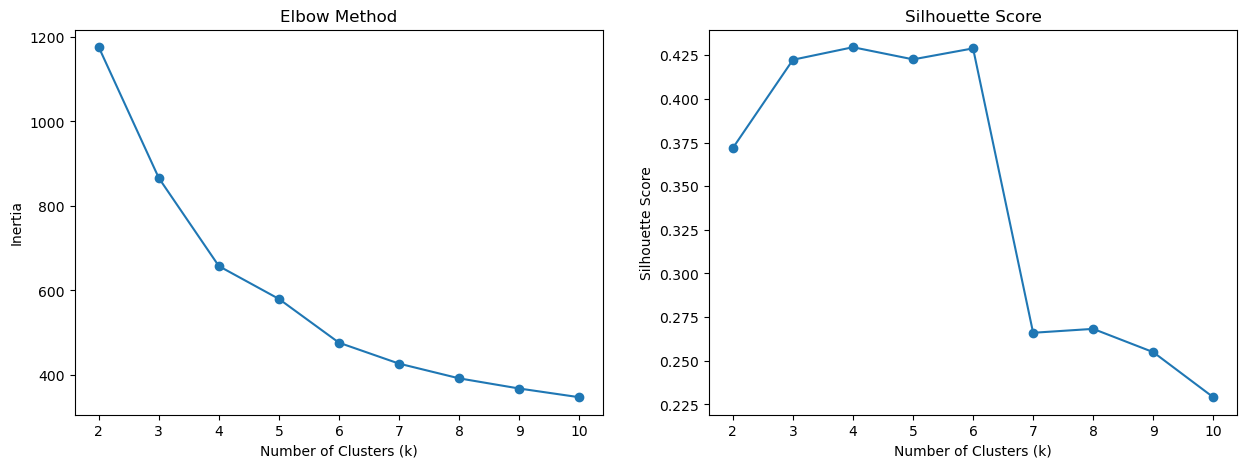

In [58]:
# Find optimal k using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    clusters = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, clusters))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(k_values, inertia, marker='o')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')

ax2.plot(k_values, silhouette_scores, marker='o')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')

plt.show()

### As can be seen in the Elbow Method graph above, the convenient number of clusters is 6 since the curve bends at 6.

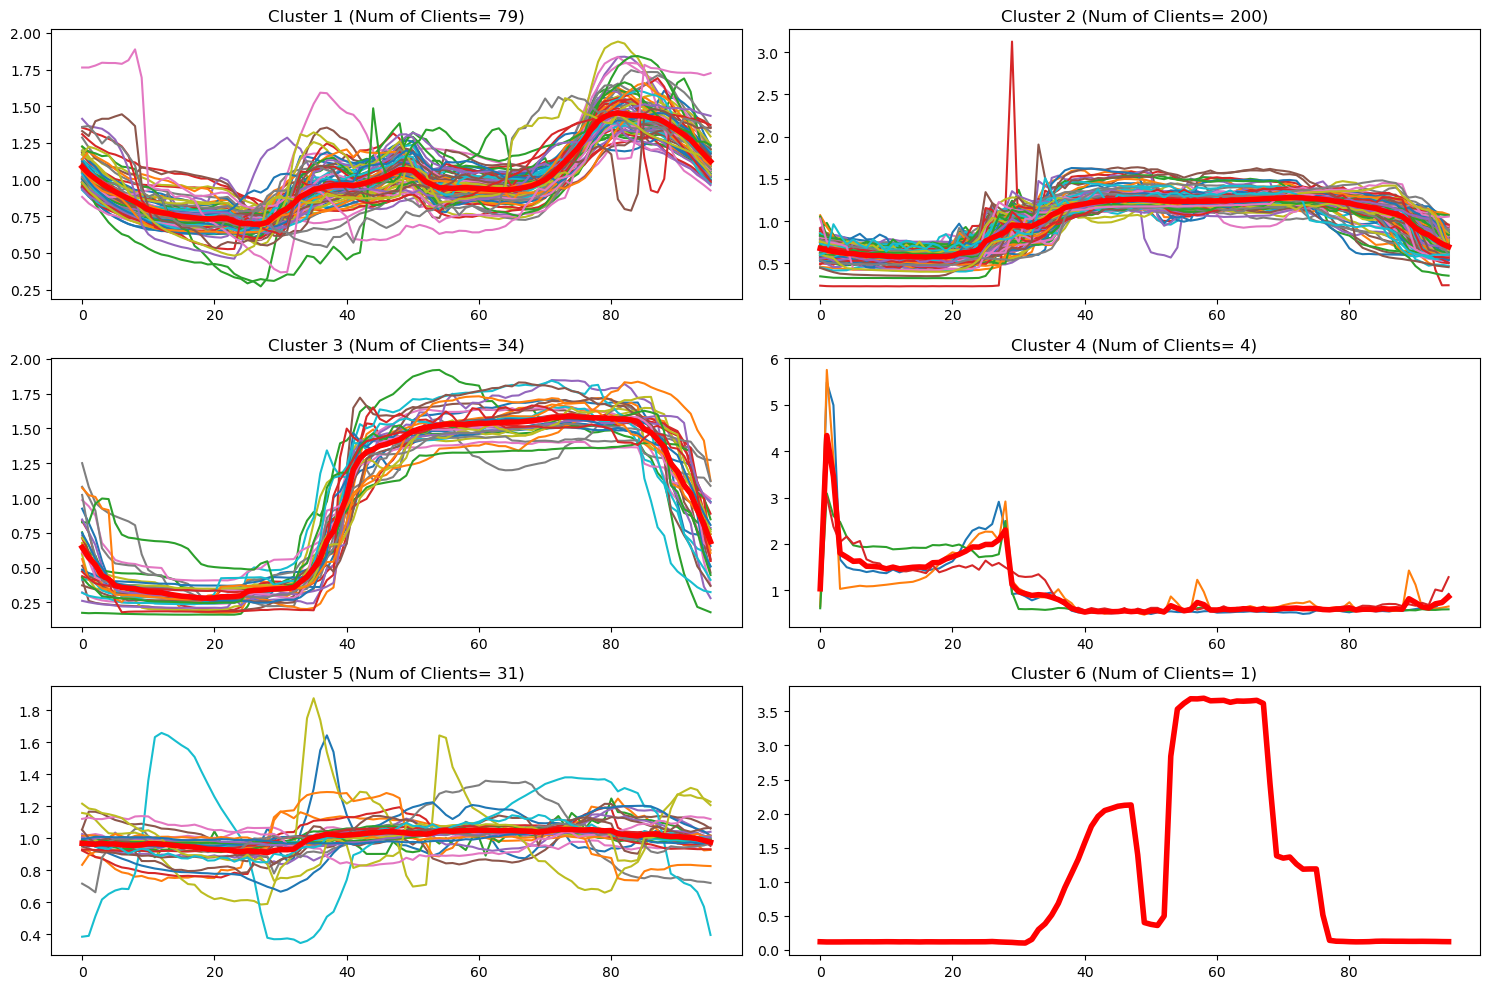

In [62]:
# plot for each cluster

opt_k=6 # optimal number of clusters
model = KMeans(n_clusters=opt_k, random_state=42, n_init=10).fit(X)  # The model

# Plots each cluster
plt.figure(figsize=(15, 10))
for cluster in range(opt_k):
    plt.subplot(3, 2, cluster + 1)
    plt.plot(X[model.labels_==cluster].T)
    plt.plot(model.cluster_centers_[cluster],linewidth=4, color='red')
    plt.title(f'Cluster {cluster + 1} (Num of Clients= {str(sum(model.labels_==cluster))})')
plt.tight_layout()
plt.show()

In [83]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

**Q2: (8 marks)**

In this exercise you work with the daily curves of 1 single client.
First, create a list of arrays, each array containing a curve for a day. You may use X from the cells above.
    X = average_curves_norm.copy() 
The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value of k ( number of clusters). This time you may also perform silhoutte analysis as stated in the module. Carrying out silhoutte analysis is left as an exercise. What do you understand about the clusters? 

b. Based on your results from your analyses of both methods, what do understand?  Interpret it perhaps with different perspectives of timelines like weeks or months.

In [96]:
# Normalize data
#X_norm = X/np.mean(X)
X_norm = [X/np.mean(X) for X in X]

In [98]:
len(X_norm[0])

96

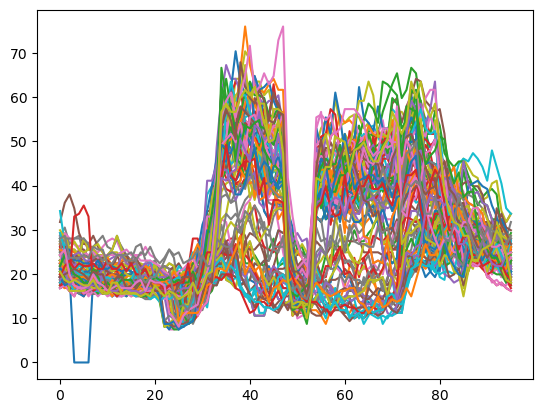

In [108]:
import random as rand
n_obs=100
rand_obs = [rand.randint(0,729) for x in range(1,n_obs)]

for i in rand_obs:
    plt.plot(X[i])

plt.rcParams["figure.figsize"] = [14,6]
plt.show()

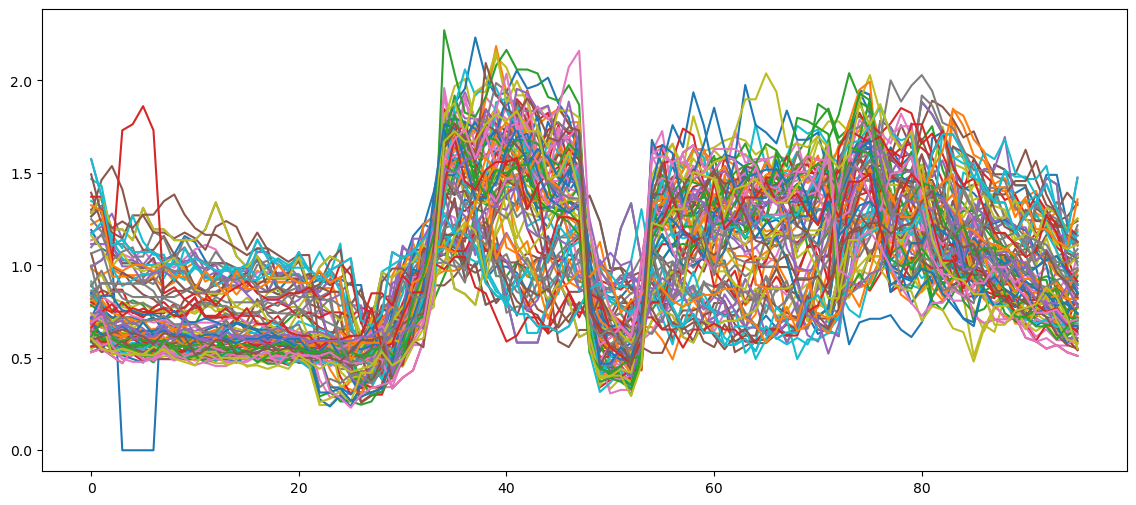

In [110]:
#explore normlaized data
for i in rand_obs:
    plt.plot(X_norm[i])

plt.rcParams["figure.figsize"] = [14,6]
plt.show()

In [144]:
# Computing 3 performance measures for a range of values of  k

inertias = []
silhouettes = []
opt_k = 16
# run functions for each value of k
for k in np.arange(1,opt_k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_norm)    
    inertias = inertias + [kmeans.inertia_]
    if k>1:
        silhouettes = silhouettes + [silhouette_score(X, kmeans.labels_)]

C:\Users\frank\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\frank\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\frank\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\frank\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

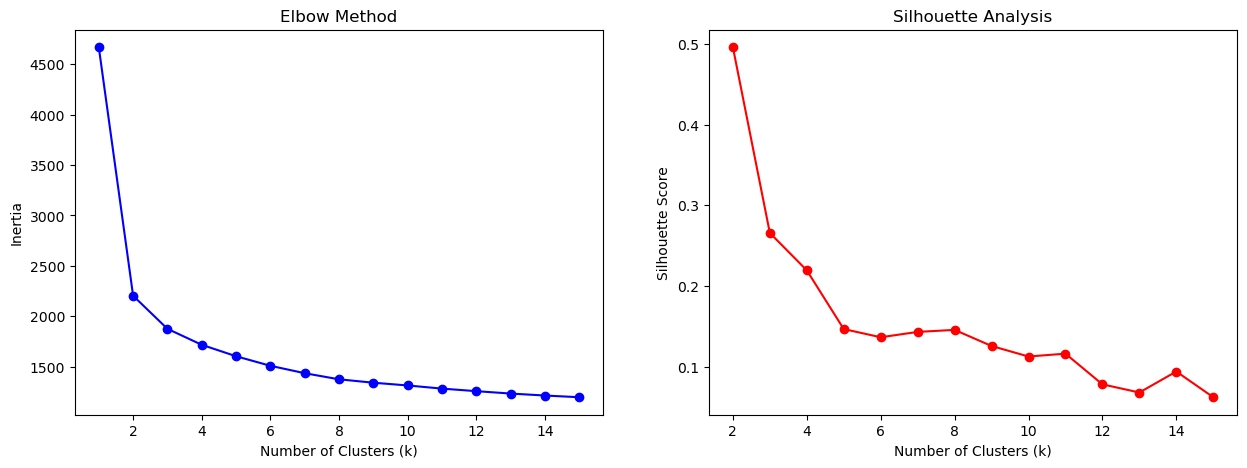

In [150]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(np.arange(1,opt_k), inertias, marker='o', color='b')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')

ax2.plot(np.arange(2,opt_k), silhouettes, marker='o', color='r')
ax2.set_title('Silhouette Analysis')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')

plt.show()

### The optimal value of k is 2

C:\Users\frank\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Figure size 1200x400 with 0 Axes>

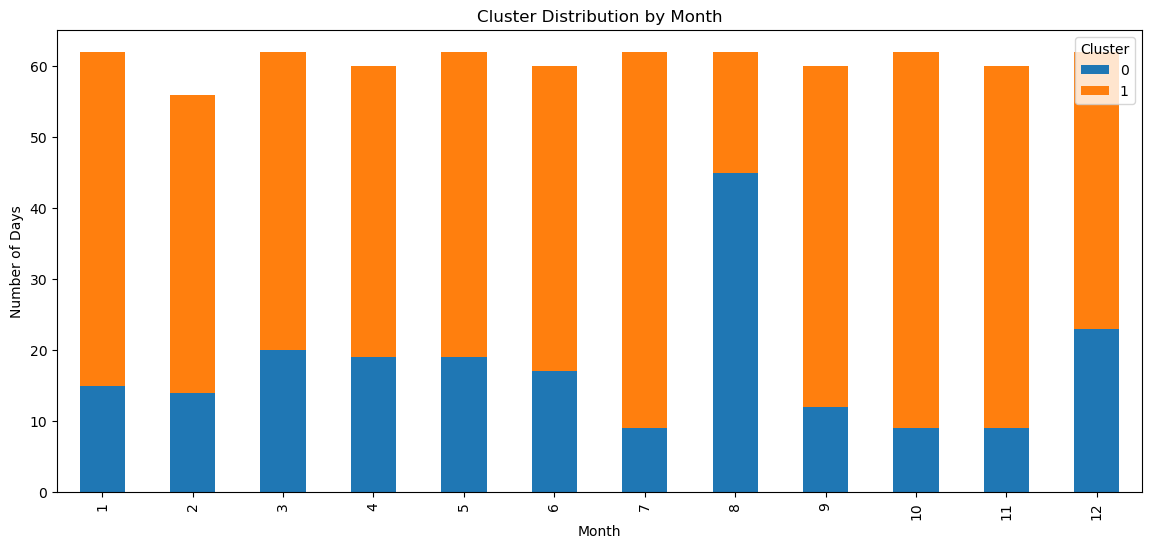

<Figure size 1200x400 with 0 Axes>

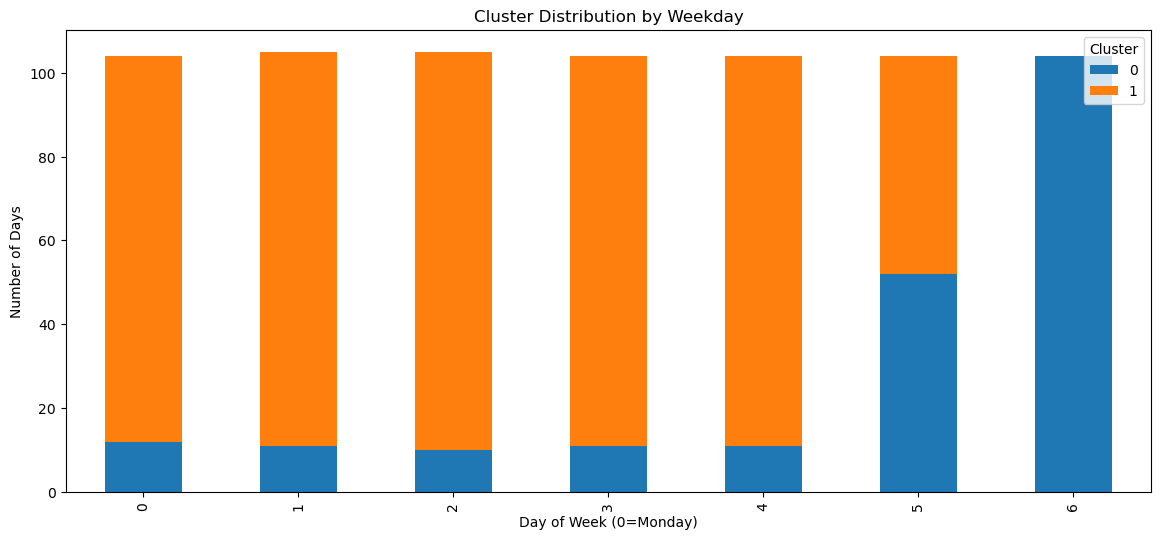

In [156]:
# Fit K-Means with optimal k=2
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_norm)
#centroids = kmeans.cluster_centers_.reshape(3, n_time_points)  # Shape: (3, time_points)
# Map clusters to dates
dates = pd.date_range(start='2013-01-01', end='2014-12-31', freq='D')
cluster_df = pd.DataFrame({'Date': dates, 'Cluster': cluster_labels})
cluster_df['Month'] = cluster_df['Date'].dt.month
cluster_df['DayOfWeek'] = cluster_df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday

# Plot monthly distribution
plt.figure(figsize=(12, 4))
cluster_df.groupby(['Month', 'Cluster']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Cluster Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Number of Days')
plt.legend(title='Cluster')
plt.show()

# Plot weekday distribution
plt.figure(figsize=(12, 4))
cluster_df.groupby(['DayOfWeek', 'Cluster']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Cluster Distribution by Weekday')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Number of Days')
plt.legend(title='Cluster')
plt.show()

### Cluster 0 has a peak in electricity usage during weekends. Also we can see that cluster 1 peaks in the winter month, probably due to the demand for heating.

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b).  The cells below are only to give you a headstart.  You may or may not use these and come up with your own interpretation.


In [ ]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [ ]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

Continue with your analysis here: